## Análise com redis

### Objetivo

Gerar insights com estruturas de dados probabilísticas e analisar esses insights comparando-os com insights obtidos de forma clássica. 

O redis é uma ferramenta muito poderosa, mas assim como os métodos clássicos precisamos de algumas atenções, em especial o tratamento dos dados pré-processamento e pré inserção no redis. A seguir vamos criar um ambiente redis e começar o tratamento pré-processamento.

In [2]:
# Atenção, precisa ter docker instalado na máquina para rodar esse programa
# Abra o docker desktop se possível
!docker run -d --name redis-stack -p 6379:6379 -p 8001:8001 redis/redis-stack:latest

a11c3319152cb39c3a843bdbd06eeda416cd1716b880f63b57c3c6fd2a6e2946


Unable to find image 'redis/redis-stack:latest' locally
latest: Pulling from redis/redis-stack
a2d56dac7fbe: Pulling fs layer
2c0937dd2c62: Pulling fs layer
8259dfe192da: Pulling fs layer
4f4fb700ef54: Pulling fs layer
af6eca94c810: Pulling fs layer
59fbe10511c3: Pulling fs layer
4f4fb700ef54: Pulling fs layer
ef746faa6c83: Pulling fs layer
6f586d774aa5: Pulling fs layer
e02e663fe7b5: Pulling fs layer
c2e320d41856: Pulling fs layer
44190ad1f55f: Pulling fs layer
5aeac081ab04: Pulling fs layer
53acfac450a4: Pulling fs layer
6acd66da55e4: Pulling fs layer
4d8c94c7ecbd: Pulling fs layer
273bca046af3: Pulling fs layer
c2e320d41856: Download complete
6acd66da55e4: Download complete
44190ad1f55f: Download complete
53acfac450a4: Download complete
4d8c94c7ecbd: Download complete
5aeac081ab04: Download complete
4f4fb700ef54: Download complete
e02e663fe7b5: Download complete
6f586d774aa5: Download complete
8259dfe192da: Download complete
a2d56dac7fbe: Download complete
af6eca94c810: Download com

Vamos nesse primeiro momento descretizar nossos dados, e por que temos que fazer isso? 

Os algoritmos e estruturas que vamos usar são muito bons em encontrar padrões, mas nossos dados não são nem um pouco padronizados, o que queremos dizer com isso? Considere a seguinte pergunta: 

"Quantas altas relevantes tivemos no preço do bitcoin de 01/01/2024 até 01/03/2024?"

Essa pergunta parece fácil de ser respondida no primeiro momento, mas o que seria uma alta relevante e como a gente categoriza isso? 

Usamos uma técnica chamada de Binning (Discretização), existem muitas formas de aplicar essa técina, mas achamos melhor seguir com a abordagem a seguir. Nossa abordagem consiste em criar agrupamentos de dados como buckets para que seja mais fácil detectar padrões, imagine que a gente pegue a variação percentual do bitcoin relativa ao seu dia anterior, podemos ter valores como: 

* 0.1321 -> 13%
* 0.0192 -> 1%
* -0.0531 -> -5%

Ou seja, temos valores muito distintos, é pouco provável que se analisarmos os dados crus o redis gere insights relevantes.

In [24]:
import yfinance as yf
import pandas as pd
import redis
import numpy as np

# Conexão com o Redis
r = redis.Redis(host='localhost', port=6379, decode_responses=True)

btc = yf.download('BTC-USD', period='max')
btc.columns = btc.columns.droplevel('Ticker')  # Limpeza do MultiIndex se necessário

# Discretização para Count-Min Sketch: Categorizar retorno diário
btc['returns'] = btc['Close'].pct_change()


def categorize_return(val):
    if val > 0.05:
        return 'Super_Alta'
    elif val > 0.01:
        return 'Alta'
    elif val > -0.01:
        return 'Estavel'
    elif val > -0.05:
        return 'Queda'
    else:
        return 'Crash'


btc['market_mood'] = btc['returns'].apply(categorize_return)

print(btc[['Close', 'price_bin', 'market_mood']].head())

C:\Users\kaueo\AppData\Local\Temp\ipykernel_15208\638056155.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  btc = yf.download('BTC-USD', period='max')
[*********************100%***********************]  1 of 1 completed

Price            Close price_bin market_mood
Date                                        
2014-09-17  457.334015        0k       Crash
2014-09-18  424.440002        0k       Crash
2014-09-19  394.795990        0k       Crash
2014-09-20  408.903992        0k        Alta
2014-09-21  398.821014        0k       Queda


In [25]:
# Criar a chave do Bloom Filter
bf_patterns_key = "btc_patterns_bf"
r.delete(bf_patterns_key)
r.bf().reserve(bf_patterns_key, 0.01, 1000)

moods = btc['market_mood'].tolist()
patterns = []
for i in range(len(moods)-2):
    # Pega 3 dias seguidos e junta com traço
    pattern = f"{moods[i]}-{moods[i+1]}-{moods[i+2]}"
    patterns.append(pattern)
    r.bf().add(bf_patterns_key, pattern)

print(f"Padrões de 3 dias indexados: {len(patterns)}")

Padrões de 3 dias indexados: 4089


In [26]:
queries = [
    "Queda-Queda-Queda",       # O mercado já caiu 3 dias seguidos?
    "Super_Alta-Super_Alta-Super_Alta", # Já tivemos 3 dias de super alta seguidos?
    "Crash-Super_Alta-Crash",  # Volatilidade extrema (sobe e desce loucamente)?
    "Estavel-Estavel-Estavel"  # Tédio total por 3 dias?
]

for q in queries:
    exists = r.bf().exists(bf_patterns_key, q)
    print(f"Padrão [{q}]: {'JÁ OCORREU' if exists else 'NUNCA VISTO'}")

Padrão [Queda-Queda-Queda]: JÁ OCORREU
Padrão [Super_Alta-Super_Alta-Super_Alta]: JÁ OCORREU
Padrão [Crash-Super_Alta-Crash]: JÁ OCORREU
Padrão [Estavel-Estavel-Estavel]: JÁ OCORREU


Podemos responder perguntas de sim ou não com o redis, assim como fizemos agora. Basta utilizar das técnicas aqui apresentadas, Binning, criação de indices e manipulação dos dados. Vamos fazer uma outra consulta para outro exemplo: 

In [39]:
btc = yf.download('BTC-USD', period='max')
btc.columns = btc.columns.droplevel('Ticker')
btc['returns'] = btc['Close'].pct_change()
# print(btc['returns'].head())


def categorize_with_value(val):
    if pd.isna(val):
        return "Invalido"

    pct = int(round(val * 100))
    # pct = abs(pct)

    if val > 0.05:
        return f'Super_Alta_{pct}%'
    elif val > 0.01:
        return f'Alta_{pct}%'
    elif val > -0.01:
        return f'Estavel_{pct}%'
    elif val > -0.05:
        return f'Queda_{pct}%'
    else:
        return f'Crash_{pct}%'


btc['Market_mood_value'] = btc['returns'].apply(categorize_with_value)

bf_patterns_key = "btc_patterns_bf"
r.delete(bf_patterns_key)
r.bf().reserve(bf_patterns_key, 0.01, 1000)

patterns = []
moods = btc['Market_mood_value'].to_list()

for i in range(len(moods)):
    patterns.append(moods[i])
    r.bf().add(bf_patterns_key, moods[i])

queries = [
    "Crash_15%",
    "Super_Alta_15%"
]

for q in queries:
    exists = r.bf().exists(bf_patterns_key, q)
    print(f"Padrão [{q}]: {'JÁ OCORREU' if exists else 'NUNCA VISTO'}")

C:\Users\kaueo\AppData\Local\Temp\ipykernel_15208\943491578.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  btc = yf.download('BTC-USD', period='max')
[*********************100%***********************]  1 of 1 completed


Padrão [Crash_15%]: NUNCA VISTO
Padrão [Super_Alta_15%]: JÁ OCORREU


In [40]:
def testar_cms(width, depth):
    cms_key = "btc_mood_cms"
    r.delete(cms_key)
    r.cms().initbydim(cms_key, width=width, depth=depth)

    moods_list = btc['Market_mood_value'].tolist()
    for mood in moods_list:
        r.cms().incrby(cms_key, [mood], [1])

    results = []
    unique_events = btc['Market_mood_value'].unique()

    for event in unique_events:
        estimated_count = r.cms().query(cms_key, event)[0]
        real_count = len(btc[btc['Market_mood_value'] == event])

        results.append({
            "Evento": event,
            "Real": real_count,
            "Estimado": estimated_count,
            "Erro": estimated_count - real_count
        })

    df_results = pd.DataFrame(results).sort_values(by='Real', ascending=False)

    print(f"\n--- TESTE: Width={width} | Depth={depth} ---")
    print(df_results.head(10))

    erros = df_results[df_results['Erro'] > 0]
    if not erros.empty:
        print(f"Houve erro em {len(erros)} itens (Colisões detectadas).")
    else:
        print("Precisão de 100% (Sem colisões).")


testar_cms(2000, 5)


--- TESTE: Width=2000 | Depth=5 ---
         Evento  Real  Estimado  Erro
9    Estavel_0%   907       907     0
14      Alta_2%   360       360     0
4    Estavel_1%   343       343     0
11  Estavel_-1%   338       338     0
3     Queda_-2%   320       320     0
16      Alta_1%   282       282     0
10      Alta_3%   234       234     0
7     Queda_-1%   228       228     0
6     Queda_-3%   202       202     0
2       Alta_4%   161       161     0
Precisão de 100% (Sem colisões).


Podemos notar que não houve nenhum erro pelo redis, isso é ótimo, mas por que isso acontece? 

O algoritmo usado Count-min Sketch conta a repetição dentro de eventos, podemos ver na sua configuração. Exemplo próximo ao código:
```python 

    testar_cms(2000, 5)
    r.cms().initbydim(cms_key, width=2000, depth=5) #
```

### Teoria do estacionamento: 

De forma simplficada podemos dizer que essa função do redis se comporta como um grande estacionamento com 2000 vagas. Certo, mas e os carros? Serião os valores **únicos** para as ocorrências de Market_Mood_Values. Podemos estimar que esses valores únicos não estão nem próximos de ter o mesmo tamanho que 2000, ou seja, temos mais vagas do que carros neste caso, o que deixa fácil para o redis ter sua estimativa o mais precisa possível, mas nem sempre conseguimos dimensionar nosso problema de forma tão bela.

### Forçando erro no redis

Vamos criar um estacionamento menor dessa vez

In [41]:
testar_cms(20,5)


--- TESTE: Width=20 | Depth=5 ---
         Evento  Real  Estimado  Erro
9    Estavel_0%   907       953    46
14      Alta_2%   360       361     1
4    Estavel_1%   343       344     1
11  Estavel_-1%   338       338     0
3     Queda_-2%   320       320     0
16      Alta_1%   282       288     6
10      Alta_3%   234       234     0
7     Queda_-1%   228       233     5
6     Queda_-3%   202       203     1
2       Alta_4%   161       161     0
Houve erro em 33 itens (Colisões detectadas).


podemos ver que "estouramos o estacionamento" do redis e portanto temos colisões e erros, mas fique tranquilo por que tudo está previsto pela estatística.

Os insights que o redis nos tras é muito bom, mas vem com uma responsabilidade de pre-processar os dados de forma correta, algo que não é muito difícil. Em comparação com datasets grandes tivemos uma ótima vantagem nesse estudo pelo uso da lib yfinance, mas podemos observar que o redis é super leve.

### Insights

Dentro desse estudo usamos uma métrica famosa que são 3 quedas relevantes em sequência e observamos isso através do bloom filter, isso nos da um ótimo indicativo que bitcoin é um investimento de risco e bem volatíl. Podemos observar também através do **Bloom Filter** que nunca houve uma queda de 15% o que nos tras um insight bem bacana mostrando que o bitcoin tende a ter altas grandes mas não quedas repentinas.

Outro insight muito bacana que **CMS** nos trouxe é que em sua maioria eventos de alta e de estabilidade dentro de 1% são bem mais comuns do que eventos de quedas, o que prova que uma das frases repetidas no início desse notebook é verdade, como dito anteriormente: bitcoin tem tendências de alta com quedas exporádicas. Isso nos tras, segurança de investimento, confiaça que o bitcoin tende a subir ao longo prazo. 

### Custo benefício

Consideramos que usar o redis é uma ótima opção. Pontos positivos: 
* Pouco uso de processamento
* Pouco uso de armazenamento
* Pouco uso de rede
* Insights claros
* Respostas velozes
* Facilidade de montar queries

Pontos negativos: 
* Pode ser difícil obter respostas mais específicas dependendo do algoritmo usado
* Mais técnico do que a abordagem clássica
* Precisa de proeficiência para funcionar plenamente

Ponto negativo: 

Diferente da modelagem arima os algoritmos aqui implementados não nos dão a mesma segurança e previsões para valores futuros do bitcoin. Os algoritmos aqui implementados tiveram o papel de revelar insights preciosos de forma direta para perguntas do tipo "já vimos uma queda de 15% no bitcoin?" ou "Quantas vezes o bitcoin aumentou em 2%?", ou seja, nesse caso estamos sempre falando sobre o que observamos e padrões encontrados, mas não geramos previsões.

In [42]:
server_info = r.info()

# Selecionar apenas o que interessa para não poluir
metrics = {
    'Versão do Redis': server_info['redis_version'],
    'Sistema Operacional': server_info['os'],
    'Uptime (dias)': server_info['uptime_in_days'],
    'Memória Usada (Human)': server_info['used_memory_human'],
    'Clientes Conectados': server_info['connected_clients'],
    'Comandos Processados': server_info['total_commands_processed']
}

df_server = pd.DataFrame(metrics.items(), columns=['Métrica', 'Valor'])

print("--- Status do Servidor Redis ---")
display(df_server)

--- Status do Servidor Redis ---


,Métrica,Valor
0,Versão do Redis,7.4.7
1,Sistema Operacional,Linux 6.6.87.2-microsoft-standard-WSL2 x86_64
2,Uptime (dias),0
3,Memória Usada (Human),1.45M
4,Clientes Conectados,1
5,Comandos Processados,67416


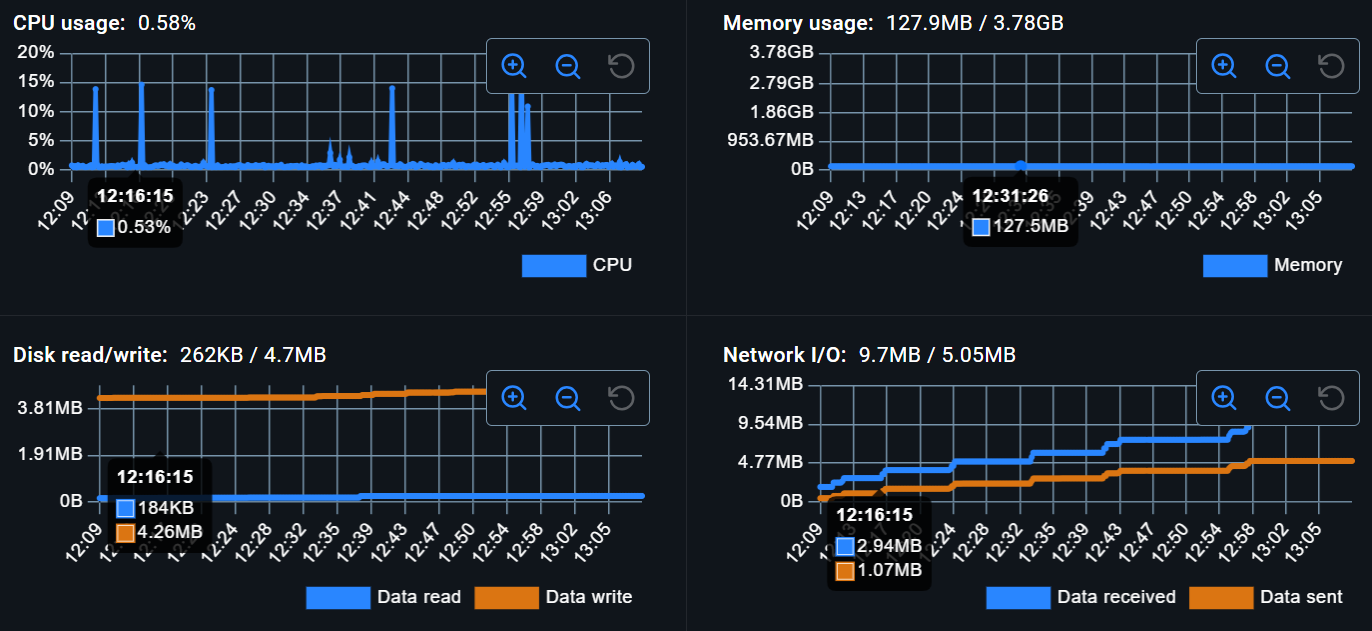

Outro ponto legal de analisar é o uso do redis com os recurssos físicos. E podemos 